# Notebook to compute the Glacier "response time" at different scales and to look into glacier model differences of response times...

In [3]:
# # these code lines above are equal to those at the beginning of 2_glacier_vs_climate_change


# download it here https://cluster.klima.uni-bremen.de/~lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc
# and change the path to your local path
DATE = 'Jun29' #'apr04' (has OGGM runaway effect of glaciers inside)

fill_option = 'repeat_last_100yrs'

import xarray as xr
import numpy as np
import pandas as pd
import scipy
import os
import glob
import matplotlib.pyplot as plt
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
# for plots withinplots 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

try:
    path_merged_runs_scaled = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
    path_merged_runs_scaled_extend = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    ds_reg_models_extend = xr.open_dataset(path_merged_runs_scaled_extend)

except:
    path_merged_runs_scaled = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
    path_merged_runs_scaled_extend = f'/home/lilianschuster/Downloads/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
    ds_reg_models_extend = xr.open_dataset(path_merged_runs_scaled_extend)

# --> comes from isimip3b_postprocessing_analysis/isimip3b_postprocess_to_monthly.ipynb
pd_global_temp_exp = pd.read_csv('../data/temp_ch_ipcc_isimip3b.csv', index_col = 0)


from help_func import pal_models, model_order, d_reg_num_name, model_order_anonymous, d_reg_num_name_sh
# remove OGGM_v153 and Huss
hue_order_anonymous = []
hue_order = model_order[:-2] 
glac_models = hue_order 
pal_models = pal_models[:-2]
pal_models = sns.color_palette(pal_models)
for m in hue_order:
    hue_order_anonymous.append(model_order_anonymous[m])

print(hue_order, hue_order_anonymous)
pal_models

# test without Zeokllari and OGGM-VAS
sel = False
if sel:
    glac_models = ['James', 'Rounce', 'Compagno', 'Kraaijenbrink', 'GLIMB', 'OGGM_v16'] #, 'OGGM-VAS', 'Zekollari'] # OGGM_v153, Huss
    ds_reg_models_extend = ds_reg_models_extend.sel(model_author=glac_models)
    ds_reg_models_vol = ds_reg_models_extend.volume_m3.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']

    # Let's take the median estimate from all glacier models for every RGI region and then do the sum:
else:    
    ds_reg_models_extend = ds_reg_models_extend.sel(model_author=glac_models)
    ds_reg_models_vol = ds_reg_models_extend.volume_m3 #.isel(simulation_year=slice(0,2000)) #['relative volume change (in %)']

# Let's take the median estimate from all glacier models for every RGI region and then do the sum:
ds_reg_models_vol = ds_reg_models_vol.stack(experiments=['gcm','period_scenario'])
ds_reg_models_med_vol = ds_reg_models_vol.median(dim='model_author')
num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 


def get_glob_temp_exp(region='global'):
    pd_global_temp_exp_glac = pd.read_csv('../data/temp_ch_ipcc_isimip3b_glacier_regionally.csv', index_col = 0)
    _p = pd_global_temp_exp_glac.loc[pd_global_temp_exp_glac.region == region]
    _p = _p.groupby(['gcm','period_scenario']).mean()
    return _p
np.testing.assert_allclose(get_glob_temp_exp(region='global')['temp_ch_ipcc'].values,
                                  pd_global_temp_exp.groupby(['gcm','period_scenario']).mean()['temp_ch_ipcc'].values, rtol=1e-5)
import matplotlib
matplotlib.__version__
pd_global_temp_exp_m = get_glob_temp_exp(region='global')


['Rounce', 'Compagno', 'Zekollari', 'OGGM_v16', 'OGGM-VAS', 'GLIMB', 'Kraaijenbrink', 'James', 'CISM2'] ['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6', 'model 7', 'model 8', 'model 9']


In [4]:
pd_global_temp_exp_m = get_glob_temp_exp(region='global')

markers = ['^', 'X','s','o','D','v']

norm = plt.Normalize(vmin=pd_global_temp_exp_m['temp_ch_ipcc'].min(),
                     vmax=pd_global_temp_exp_m['temp_ch_ipcc'].max())
cmap = sns.color_palette('flare', as_cmap=True) #sns.cubehelix_palette(light=1, as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# plot specific delta T:
col_temp_l = []
exp_l = []
for temp in [0,1.5,2,3,4,5]: #,5,6]:
    exp = np.abs(pd_global_temp_exp_m-temp).sort_values(by='temp_ch_ipcc').iloc[0].name
    #sm.colorbar.norm...
    col_temp = cmap(norm(pd_global_temp_exp_m.loc[exp]['temp_ch_ipcc']))
    col_temp_l.append(col_temp)
    exp_l.append(exp)

- only when we set a threshold of how much volume loss has to occur, we get response times that are not totally noisy 
    - much less noise, when choosing min_perc_change=25, instead of min_perc_change=10, however,it also results in more models where no response time can be estimated, which is not good. 

In [5]:
# -99,-95,-90,-80,-50,+50
def resp_time_estimate(model_author='OGGM_v16', perc_change_l=[-50],
                       rgi_reg='11', min_perc_change=20, roll_volume=20):
    # let's use per default a rolling average of 20, because every 20-years the array is repeated (even if this is done randomly)
    # computes "resp time" estimate for all 80 experiments of a given model_author and rgi_reg 
    # perc_change : -50 (gives estimates of how fast 50% of total volume change occurs)
    # HERE, the first occurrence of -50% change over the roll_volume avg. is used, 
    # alternatively we could use the last occurrence, but this would "mean" something different of course ... 
    # we also select the equilibrium volume by averaging over the last 100 years, this is necessary due to the large interdecadal variability of some models
    
    if rgi_reg == 'All':
        if model_author in global_models:
            ds_reg_models_vol_all = ds_reg_models_extend.volume_m3.sum(dim='rgi_reg')
        else:
            raise Exception("not a global model!!!")
    
    else:
        ds_reg_models_vol_all = ds_reg_models_extend.volume_m3.sel(rgi_reg=rgi_reg) # .sel(simulation_year=slice(0,2000)) # need to do the interpolation first !!!!

    ds_reg_models_vol_all = ds_reg_models_vol_all.stack(experiments=['gcm','period_scenario'])
    ds_reg_models_vol_all = ds_reg_models_vol_all.assign_coords(temp_ch_ipcc = ('experiments',
                                                                      pd_global_temp_exp_m.loc[ds_reg_models_vol_all.experiments, # make sure that we use the same experiments
                                                                                               'temp_ch_ipcc']))
    ds_reg_models_sel_vol_all = ds_reg_models_vol_all.sel(model_author=model_author)
    # equilibrium response time is the average of the last 100 years!!!
    v_eq = ds_reg_models_sel_vol_all.sel(simulation_year=slice(4901,5000)).mean(dim='simulation_year')
    v0 = ds_reg_models_sel_vol_all.isel(simulation_year=0)
    
    pd_category_resp_time = pd.DataFrame(index=ds_reg_models_vol_all.experiments)
    if rgi_reg == 'All':
        pd_category_resp_time['rgi_reg'] = f'All'
    else:
        pd_category_resp_time['rgi_reg'] = f'RGI{rgi_reg}'
    pd_category_resp_time['model_author'] = model_author
    pd_category_resp_time['min_perc_change'] = min_perc_change
    pd_category_resp_time.loc[ds_reg_models_vol_all.experiments, 'temp_ch_ipcc']  = ds_reg_models_vol_all.temp_ch_ipcc.values
    # did it grow, shrink or stay the same???
    pd_category_resp_time['category'] = r'similar to V$_{0}$'
    grow_exps = v_eq.where(v_eq/v0 >=1+min_perc_change/100, drop=True).experiments.values
    pd_category_resp_time.loc[grow_exps, 'category'] = 'grow'
    shrink_exps = v_eq.where(v_eq/v0 <=1-min_perc_change/100, drop=True).experiments.values
    pd_category_resp_time.loc[shrink_exps, 'category'] = 'shrink'
    
    for perc_change in perc_change_l:
        # response time computation
        # V(resp_t) = -perc/100 * (V_eq-v0)+v0)
        # we need the absolute because we only want to have either shrinking (negative perc) or growing (positive perc) 
        # experiments
        v_resp_t = v0 + (perc_change/100)*np.abs(v0-v_eq)
        #condi1 = (v_eq <= v_resp_t) & (v_resp_t <= v0)  # shrinking
        #condi2 = (v_eq >= v_resp_t) & (v_resp_t >= v0)
        #print(condi1, condi2, v_resp_t)
        #assert np.all(condi1 | condi2)
        v_roll = ds_reg_models_sel_vol_all.rolling(simulation_year=roll_volume, center=True).mean()
        # we take the last year where the anti-condition holds true (so it is basically the first year where the condition holds true)
        resp_t = v_roll.where(v_roll<=v_resp_t).idxmax(dim='simulation_year')
        if perc_change<0:
            # if we look at how much it shrinks it should at least shrink by min_perc_change to estimate a "response time"
            resp_t = resp_t.where(v_eq/v0 <=1-min_perc_change/100, np.NaN)
        else:
            # if we look at how much it grows it should at least grow by min_perc_change to estimate a "response time"
            #print(resp_t, v_eq/v0)
            resp_t = resp_t.where(v_eq/v0 >=1+min_perc_change/100, np.NaN)
        if perc_change>0:
            perc_change_i = f'+{perc_change}'
        else:
            perc_change_i = perc_change
        pd_category_resp_time.loc[resp_t.experiments,f'resp_time_{perc_change_i}%'] = resp_t.values
    
    return pd_category_resp_time #, resp_t, v_eq/v0

In [5]:
# test
rgi_regs = []
for rgi_reg in np.arange(1,20,1):
    if rgi_reg < 10:
        rgi_reg = '0'+str(rgi_reg)
    else:
        rgi_reg = str(rgi_reg)
    rgi_regs.append(rgi_reg)

for model_author in ['OGGM_v16', 'OGGM-VAS', 'Compagno']:
    for rgi_reg in rgi_regs:
        pd_test = resp_time_estimate(model_author=model_author, perc_change_l=[-50],
                           rgi_reg=rgi_reg, min_perc_change=20)
        pd_test = pd_test.dropna()

        for j,ind in enumerate(pd_test.index):
            ds_test = ds_reg_models_extend.volume_m3.sel(model_author=model_author, rgi_reg=rgi_reg).stack(experiments=['gcm','period_scenario']).sel(experiments=pd_test.index[j])
            ds_test = ds_test.rolling(simulation_year=5, center=True).mean()
            vol_change_at_resp_time_yr = ds_test[0]-ds_test.sel(simulation_year = pd_test.iloc[j]['resp_time_-50%'])
            np.testing.assert_allclose(vol_change_at_resp_time_yr, 0.5*(ds_test[0]-ds_test[-1]), rtol=0.003)

In [6]:
pd_test = resp_time_estimate(model_author='OGGM_v16', perc_change_l=[+50],
                           rgi_reg='03', min_perc_change=10)

In [7]:
pd_test.sort_values(by=['resp_time_+50%']).dropna()

,rgi_reg,model_author,min_perc_change,temp_ch_ipcc,category,resp_time_+50%
experiments,,,,,,
"(mpi-esm1-2-hr, 1951-1970_hist)",RGI03,OGGM_v16,10,0.293009,grow,409.0
"(mpi-esm1-2-hr, 1851-1870_hist)",RGI03,OGGM_v16,10,0.023374,grow,500.0
"(ipsl-cm6a-lr, 1901-1920_hist)",RGI03,OGGM_v16,10,-0.203529,grow,559.0
"(ukesm1-0-ll, 1951-1970_hist)",RGI03,OGGM_v16,10,0.177421,grow,659.0
"(mpi-esm1-2-hr, 1901-1920_hist)",RGI03,OGGM_v16,10,0.041656,grow,667.0
"(ukesm1-0-ll, 1851-1870_hist)",RGI03,OGGM_v16,10,0.313095,grow,738.0


In [8]:
pd_test = resp_time_estimate(model_author='James', perc_change_l=[-50],
                           rgi_reg='06', min_perc_change=25)
pd_test.dropna().min()

rgi_reg               RGI06
model_author          James
min_perc_change          25
temp_ch_ipcc       0.998767
category             shrink
resp_time_-50%         10.0
dtype: object

#### complex plot for all RGI regions ...

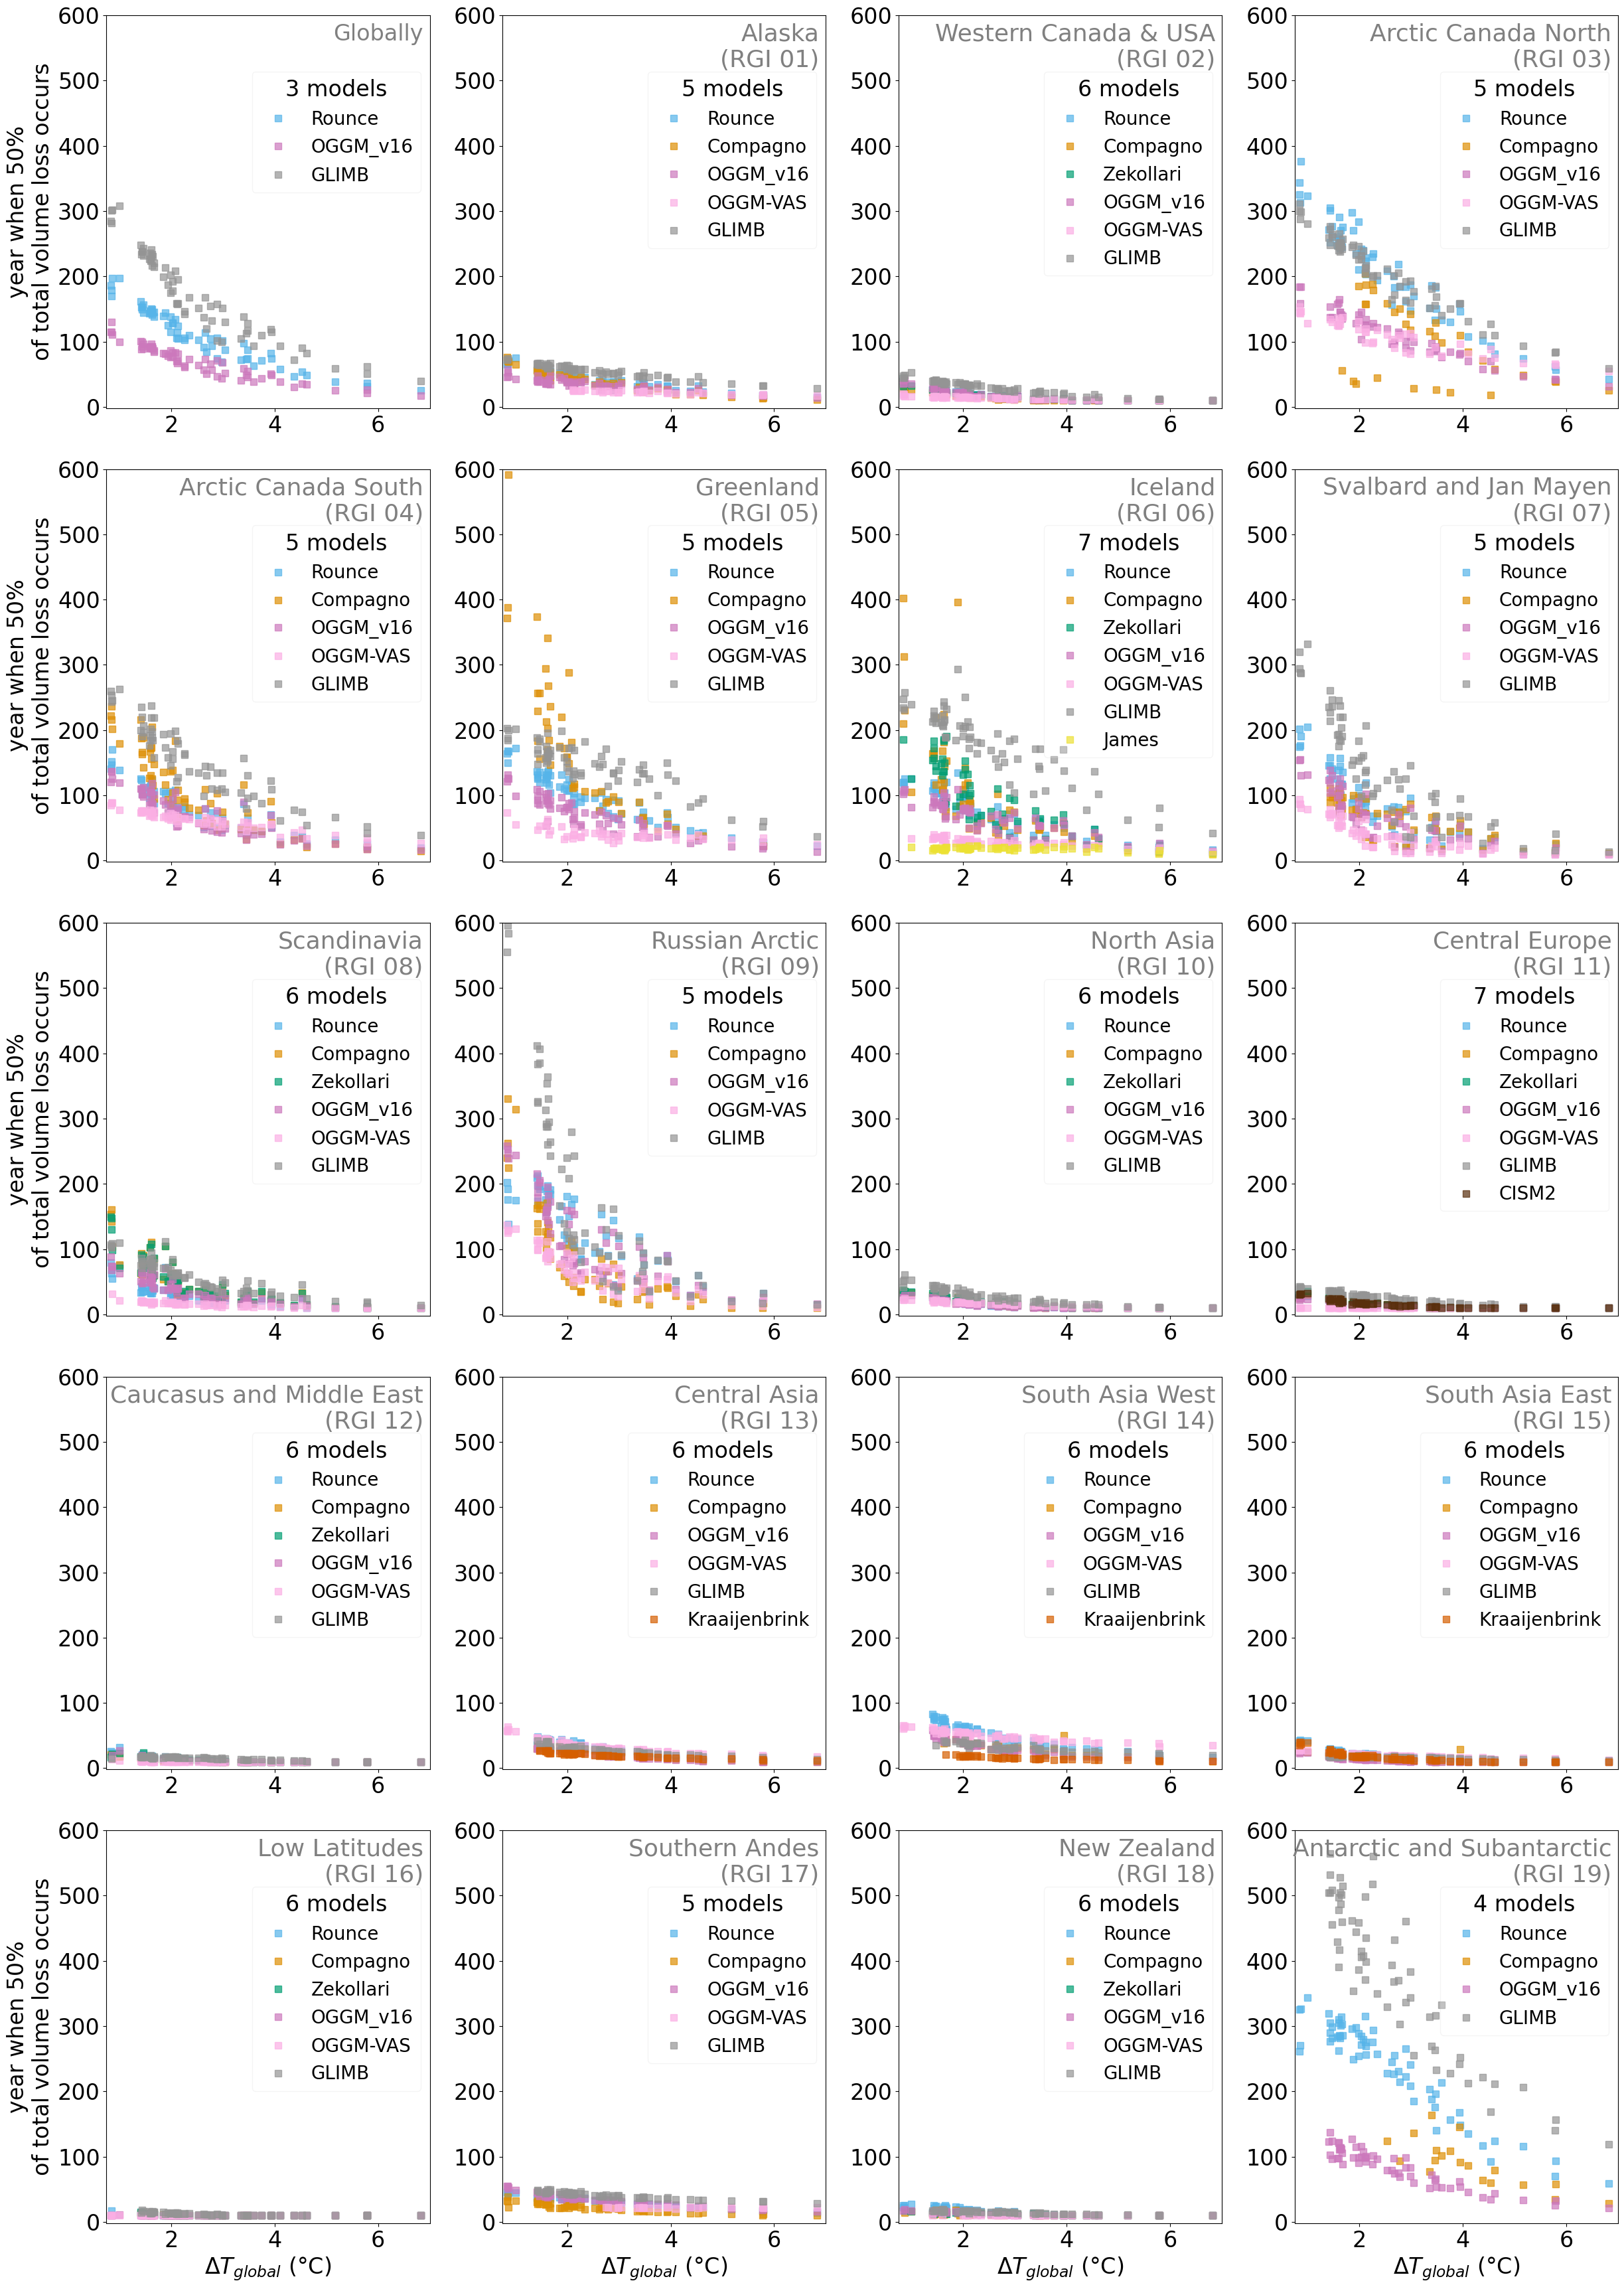

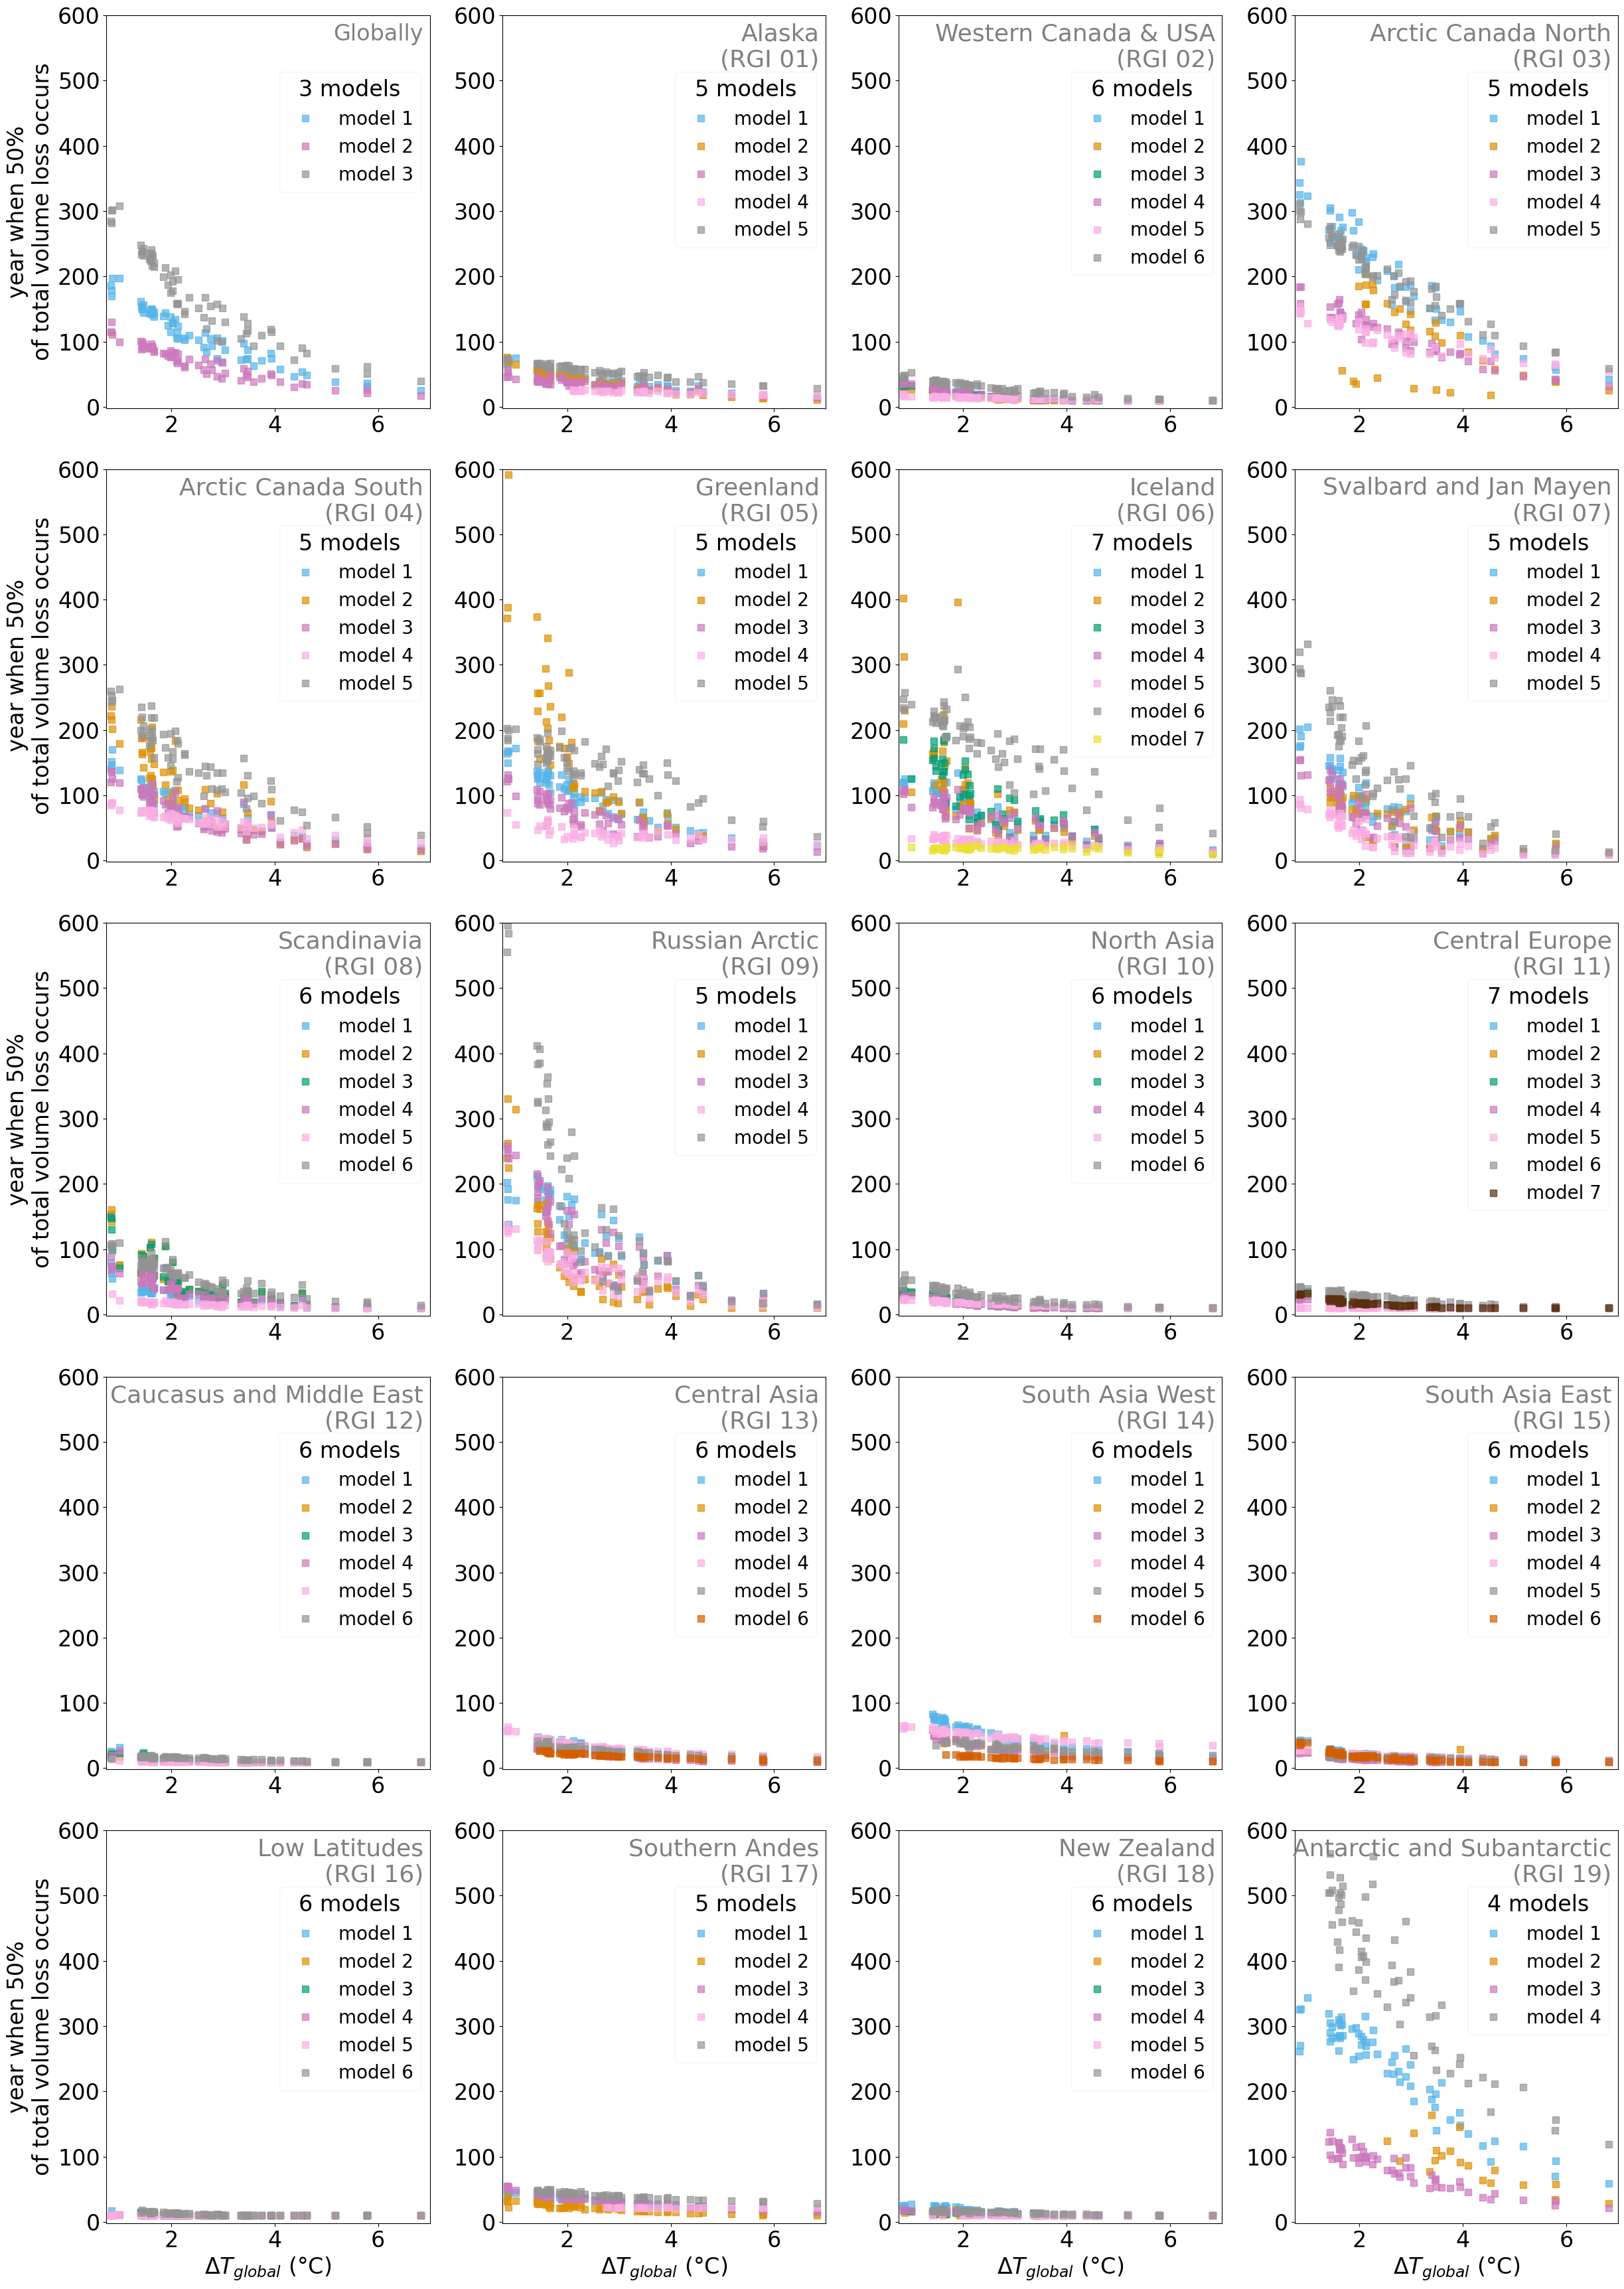

In [38]:
rgi_num_order = ['All', '19', '03', '01', '05', '09', '04', '07', '17', '06', '13', '14',
                 '02', '15', '08', '10', '11', '16', '18', '12'] # after initial volume ...

pd_reg_models_count = ds_reg_models_extend.volume_m3.sel(simulation_year=0).to_dataframe().groupby(['rgi_reg', 'model_author'])['volume_m3'].count().reset_index()
pd_reg_models_count = pd_reg_models_count.loc[pd_reg_models_count.rgi_reg !='All']
pd_reg_models_count = pd_reg_models_count.rename(columns={'volume_m3':'n_experiments'})
# models available for each region...
_regional_model = pd_reg_models_count.loc[pd_reg_models_count.n_experiments > 0 ] # ==80

## amount of models per region
reg_n_models = pd_reg_models_count.loc[pd_reg_models_count.n_experiments > 0].groupby('rgi_reg').count()['model_author'] # at least 1 experiment for that RGI region
# models that are globally available 
global_models = pd_reg_models_count.groupby('model_author').sum().where(pd_reg_models_count.groupby('model_author').sum() == 80 * 19).dropna().index

label_type = 'authors'

roll_volume=20
plt.rc('font', size=24)  
pd_category_resp_time_l = []
#min_perc_change = 25 # assume that at least 25% change is necessary to estimate a "response time"???
k = 0
for min_perc_change in [1,5,10,20,25]:
    for anonym, label_type in zip(['', '_anonym'],['authors', 'anonymous']):
        for perc in [-50,-80,-90]: #, -(1-1/np.e)*100, -90, +50]: #,1999]:
            if perc>0:
                perc_change_ii = f'+{perc}'
                perc_change_i = f'+{perc}'

            else:
                perc_change_ii = f'{int(round(perc,0))*-1}'
                perc_change_i = perc
            fig, axs = plt.subplots(5,4,figsize=(25,35)) #, sharey='row') #, sharex=True)
            rgi_regs_global = rgi_num_order
            rgi_regs_global = ['All', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12',
                   '13', '14', '15', '16', '17', '18', '19'] #'All',
            for j, rgi_reg in enumerate(rgi_regs_global):
                if j<4:
                    ax = axs[0][j]
                elif j <8:
                    ax = axs[1][j-4]
                elif j <12:
                    ax = axs[2][j-8]
                elif j <16:
                    ax = axs[3][j-12]
                elif j <20:
                    ax = axs[4][j-16]
                if rgi_reg == 'All':
                    # only take models that exist globally
                    # at the moment Rounce and Glimb, OGGM
                    n = len(global_models)
                    mj = 0
                    for c,m in zip(pal_models, model_order):
                        if m in global_models:
                            mj+=1
                            if label_type == 'anonymous':
                                label = f'model {mj}'
                            else:
                                label = m

                            pd_category_resp_time = resp_time_estimate(model_author=m, perc_change_l=[perc],
                               rgi_reg=rgi_reg, min_perc_change=min_perc_change,
                                                                      roll_volume=roll_volume)
                            if anonym=='':
                                pd_category_resp_time_l.append(pd_category_resp_time)
                            ax.plot(pd_category_resp_time['temp_ch_ipcc'],
                                     pd_category_resp_time[f'resp_time_{perc_change_i}%'], 's',
                                     markersize=7, lw=0, color=c, label = label, alpha = 0.7)
                        else:
                            pass

                else:    
                    models_available = _regional_model.loc[_regional_model.rgi_reg==rgi_reg]['model_author'].values
                    n = reg_n_models[rgi_reg]
                    mj=0
                    for c,m in zip(pal_models, model_order):
                        if m in models_available:
                            mj+=1
                            if label_type == 'anonymous':
                                label = f'model {mj}'
                            else:
                                label = m
                            pd_category_resp_time = resp_time_estimate(model_author=m, perc_change_l=[perc],
                                                                       rgi_reg=rgi_reg, min_perc_change=min_perc_change,
                                                                      roll_volume=roll_volume)
                            if anonym=='':
                                pd_category_resp_time_l.append(pd_category_resp_time)
                            ax.plot(pd_category_resp_time['temp_ch_ipcc'],
                                     pd_category_resp_time[f'resp_time_{perc_change_i}%'], 's',
                                     markersize=7, lw=0, color=c, label = label, alpha = 0.7)


                handles, labels = ax.get_legend_handles_labels()
                #if j == 0 or j ==1:
                leg1 = ax.legend(handles, labels, title =f'{n} models', fontsize=20, framealpha=0.2, loc='upper right', bbox_to_anchor=(1,0.88))
                #for c,m in zip(pal_models, ds_reg_models.model_author):
                # if I use max does not matter, I just do not 
                #ax.axhline(ds_reg_models.volume_m3.sel(simulation_year=0, rgi_reg=rgi_reg,model_author='GLIMB').max()/1e9, color='grey', label='initial volume') # , loc='upper right')
                    #ax.axhspan(ds_reg_models.volume_m3.sel(simulation_year=0, rgi_reg=rgi_reg,model_author=m).min()/1e9,
                #                ds_reg_models.volume_m3.sel(simulation_year=0, rgi_reg=rgi_reg,model_author=m).max()/1e9, alpha =0.1, color =c, label='min_max')

                #leg1.remove():
                if perc<0:
                    ax.set_ylabel(f'year when {perc_change_ii}%\nof total volume loss occurs')
                    #ax.set_ylabel(f'"Response" time (minimal total volume change: {min_perc_change}%)\n(years when {perc_change_i*-1}% of total volume loss occurs)')
                else:
                    #ax.set_ylabel(f'"Response" time (minimal total volume change: {min_perc_change}%)\n(years when {perc_change_i*-1}% of total volume gains occurs)')
                    ax.set_ylabel(f'year when {perc_change_ii}%\nof total volume gain occurs')

                ax.set_xlabel(r'$\Delta T_{global}$ (°C)') # actually now: vs median global GCM 1850-1900  ... before vs median global GCM 1995-2014
                #med_initial_vol = ds_reg_models.volume_m3.sel(simulation_year=0, rgi_reg=rgi_reg,model_author='GLIMB').max().values/1e9
                #initial_vol = f'median: {med_initial_vol:.2f}km3'
                if rgi_reg != 'All':
                    nam = d_reg_num_name[rgi_reg]
                    #ax.set_title(f'{nam} (RGI {rgi_reg})')
                    ax.text(0.98, 0.98, f'{nam}\n(RGI {rgi_reg})', color='grey', ha='right', va='top',
                            fontsize=26, transform=ax.transAxes)
                else:                            
                    ax.text(0.98, 0.98, 'Globally', color='grey', ha='right', va='top',
                            fontsize=24, transform=ax.transAxes)
                #ax.axvline(0, ls=':', color='k')

                ax.set_xlim([0.75, 7])
                if min_perc_change==25 and perc==-50:
                    ax.set_ylim([-2,600])
                if j not in [0,4,8,16,20]:
                    ax.set_ylabel('')
                if j < 16:
                    ax.set_xlabel('')
                    

            #plt.grid()
            plt.tight_layout()
            
            plt.savefig(f'figures/3_response_time/3_resp_time_scatterplot_change{perc_change_i}%_regional_vs_GMT_change_IPCC_roll_win_size{roll_volume}yr_min_perc_change{min_perc_change}_{DATE}{anonym}.png') # path_analysis + 
            if min_perc_change==25 and perc==-50:
                pass
            else:
                plt.close()
            k+=1
            
            pd_response_time_x_perc_loss = pd.concat(pd_category_resp_time_l)
    pd_response_time_x_perc_loss_comp = pd_response_time_x_perc_loss.loc[pd_response_time_x_perc_loss.rgi_reg !='All']
    pd_response_time_x_perc_loss_comp = pd_response_time_x_perc_loss_comp.groupby(['rgi_reg', 'model_author', 'temp_ch_ipcc']).mean()
    ds_response_time_x_perc_loss_comp = pd_response_time_x_perc_loss_comp.to_xarray()

    for p in [-50,-80,-90]:
        ds_response_time_x_perc_loss_comp[f'diff_resp_time_{p}%'] = ds_response_time_x_perc_loss_comp[f'resp_time_{p}%'] - ds_response_time_x_perc_loss_comp[f'resp_time_{p}%'].median(dim='model_author') 

    pd_response_time_x_perc_loss_comp = ds_response_time_x_perc_loss_comp.to_dataframe().reset_index()
    pd_response_time_x_perc_loss_comp = pd_response_time_x_perc_loss_comp.dropna()#thresh=5)

    min_t_r, max_t_r = pd_response_time_x_perc_loss_comp['temp_ch_ipcc'].min()*1.01, pd_response_time_x_perc_loss_comp['temp_ch_ipcc'].max()*1.01

    # create "classes" of global temp. change
    T0_l, T1_l = [], []
    temp_labels = []
    for t0, t1 in zip([min_t_r, 2, 4],[2, 4, max_t_r]):
        temp_label = f'{t0:.1f}°C-{t1:.1f}°C'
        condi = (pd_response_time_x_perc_loss_comp.temp_ch_ipcc <=t1)&(pd_response_time_x_perc_loss_comp.temp_ch_ipcc >=t0)
        temp_labels_length_l = len(pd_response_time_x_perc_loss_comp.loc[condi].groupby('temp_ch_ipcc').count())
        pd_response_time_x_perc_loss_comp.loc[condi, 'temp_ch_classes'] = temp_label + f' (n={temp_labels_length_l})'
    # for the summary plot using the K-means clustering in 3_fitted_glacier_response.... 
    #for p in [-50,-80,-90]:
    pd_response_time_x_perc_loss_comp.reset_index(drop=True).to_csv(f'resp_time_X%_threshold{min_perc_change}%_for_deltaT_rgi_reg_roll_volume_{roll_volume}yravg.csv')
    #pd_response_time_x_perc_loss_comp[f'resp_time_{p}%'].median(dim='model_author').to_dataframe().reset_index().to_csv(f'resp_time_X%_threshold25%_for_deltaT_rgi_reg_roll_volume_{roll_volume}yravg.csv')

- "response" time estimates with 50% loss are probably most meaningul, let's to a summary plot there:

In [25]:
dt = pd_response_time_x_perc_loss_comp.loc[pd_response_time_x_perc_loss_comp.temp_ch_ipcc>=0.8]

In [39]:
dt.where(dt['resp_time_-50%']>600).dropna()

,rgi_reg,model_author,temp_ch_ipcc,min_perc_change,resp_time_-50%,resp_time_-80%,resp_time_-90%,diff_resp_time_-50%,diff_resp_time_-80%,diff_resp_time_-90%,temp_ch_classes
5936,RGI09,GLIMB,0.844940,12.2,637.0,1607.0,2458.0,384.0,1041.0,1581.0,-0.2°C-2.0°C (n=42)
5939,RGI09,GLIMB,0.998767,12.2,875.0,1951.0,2704.0,631.0,1317.0,1524.0,-0.2°C-2.0°C (n=42)
8344,RGI12,OGGM-VAS,1.468303,12.2,1705.0,23.0,1921.0,1684.5,-27.5,1604.5,-0.2°C-2.0°C (n=42)
8416,RGI12,OGGM_v16,0.844940,12.2,1505.0,1061.0,1876.0,1484.0,1006.5,902.0,-0.2°C-2.0°C (n=42)
9135,RGI13,OGGM_v16,0.841467,12.2,1973.0,1961.0,2007.0,1933.0,1813.0,1796.0,-0.2°C-2.0°C (n=42)
11936,RGI17,OGGM-VAS,0.844940,12.2,4265.0,439.0,3754.0,4210.0,303.0,3524.0,-0.2°C-2.0°C (n=42)
12434,RGI18,GLIMB,1.645489,12.2,611.0,4208.0,3135.0,590.5,4164.5,3071.5,-0.2°C-2.0°C (n=42)
12435,RGI18,GLIMB,1.666324,12.2,3584.0,228.0,1922.0,3569.0,191.0,1506.0,-0.2°C-2.0°C (n=42)
12656,RGI18,OGGM-VAS,0.844940,12.2,3675.0,2635.0,2136.0,3652.0,1283.5,1458.5,-0.2°C-2.0°C (n=42)
12657,RGI18,OGGM-VAS,0.853313,12.2,3866.0,2430.0,3513.0,3846.5,2361.5,2979.5,-0.2°C-2.0°C (n=42)


In [40]:
len(dt.where(dt['resp_time_-50%']>600).dropna())/len(dt.where(dt['resp_time_-50%']>0).dropna())

0.004215729030382323

In [23]:
['resp_time_-50%'].quantile(0.99)

391.66000000000076

In [119]:
# compute amount of RGI regions per model 
pd_regional_sum_initial_models = ds_reg_models_extend.sel(simulation_year=0).to_dataframe()
pd_regional_sum_initial_models = pd_regional_sum_initial_models.reset_index()
#pd_reg_models = pd_reg_models.dropna()
pd_reg_models_count = pd_regional_sum_initial_models.groupby(['rgi_reg', 'model_author'])['volume_m3'].count().reset_index()
pd_reg_models_count = pd_reg_models_count.rename(columns={'volume_m3':'n_experiments'})
total_count= pd_reg_models_count.groupby('model_author').sum()

labels_l = []
labels_l_anonym = []
for j,n in enumerate((total_count/80).round(0).astype(int).loc[hue_order].values.squeeze()):
    if n==1:
        label = f'{hue_order[j]} ({n} region)'
        label_a = f'{hue_order_anonymous[j]} ({n} region)' 
    else:
        label = f'{hue_order[j]} ({n} regions)'
        label_a = f'{hue_order_anonymous[j]} ({n} regions)'
    labels_l.append(label)
    labels_l_anonym.append(label_a)

In [120]:
pd_response_time_x_perc_loss_comp.temp_ch_classes

85       -0.2°C-2.0°C (n=42)
93       -0.2°C-2.0°C (n=42)
94       -0.2°C-2.0°C (n=42)
95       -0.2°C-2.0°C (n=42)
96       -0.2°C-2.0°C (n=42)
                ...         
13595      4.0°C-6.9°C (n=8)
13596      4.0°C-6.9°C (n=8)
13597      4.0°C-6.9°C (n=8)
13598      4.0°C-6.9°C (n=8)
13599      4.0°C-6.9°C (n=8)
Name: temp_ch_classes, Length: 6846, dtype: object

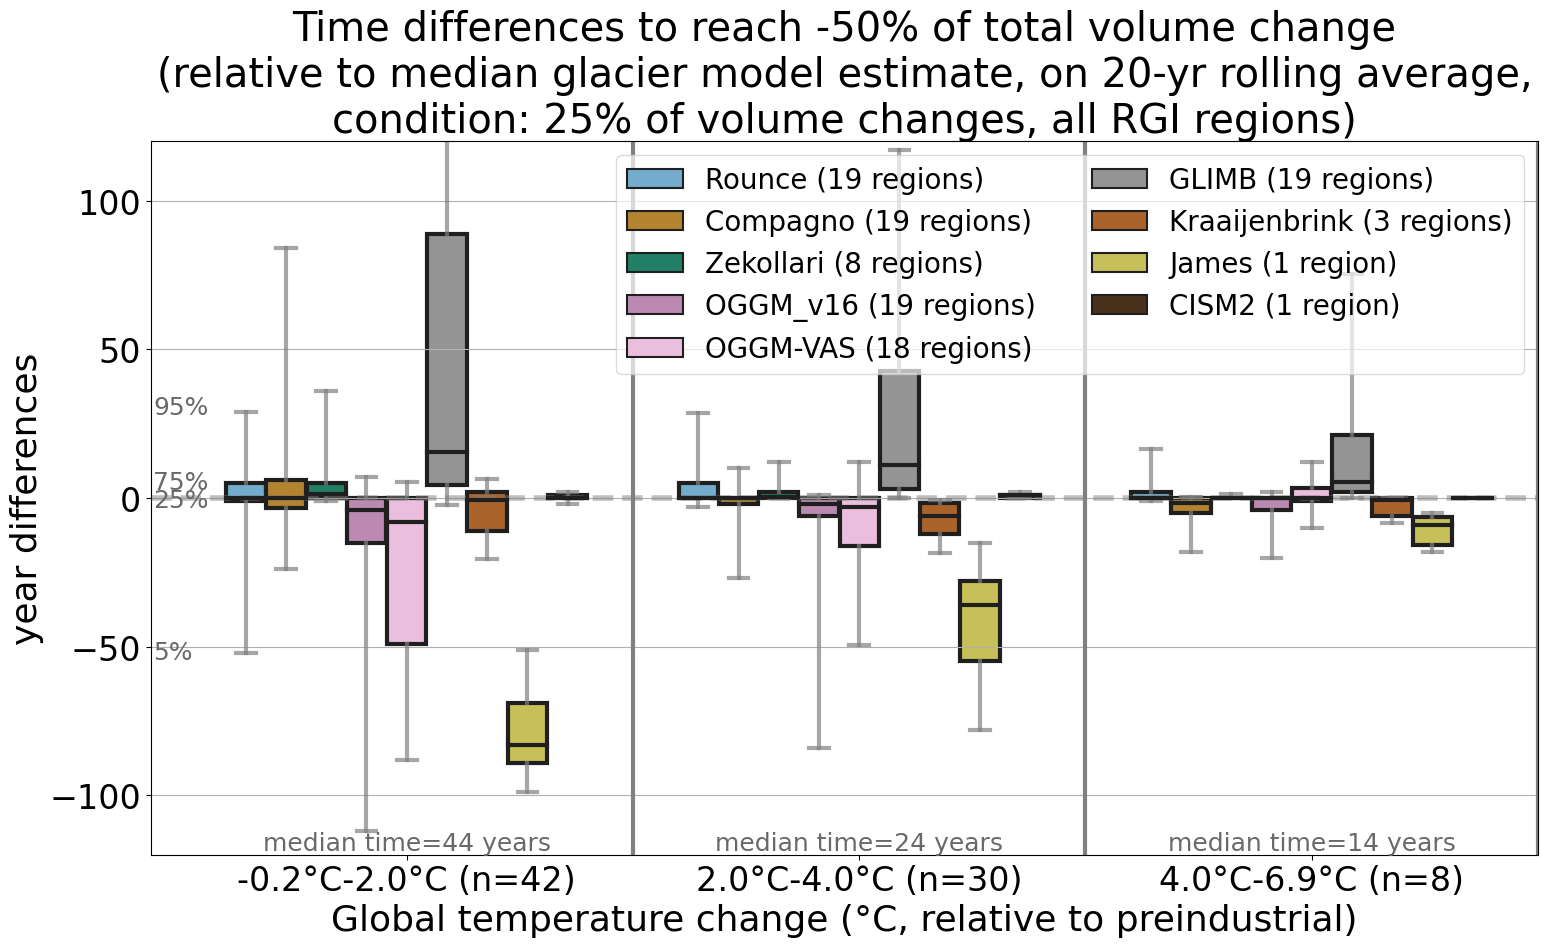

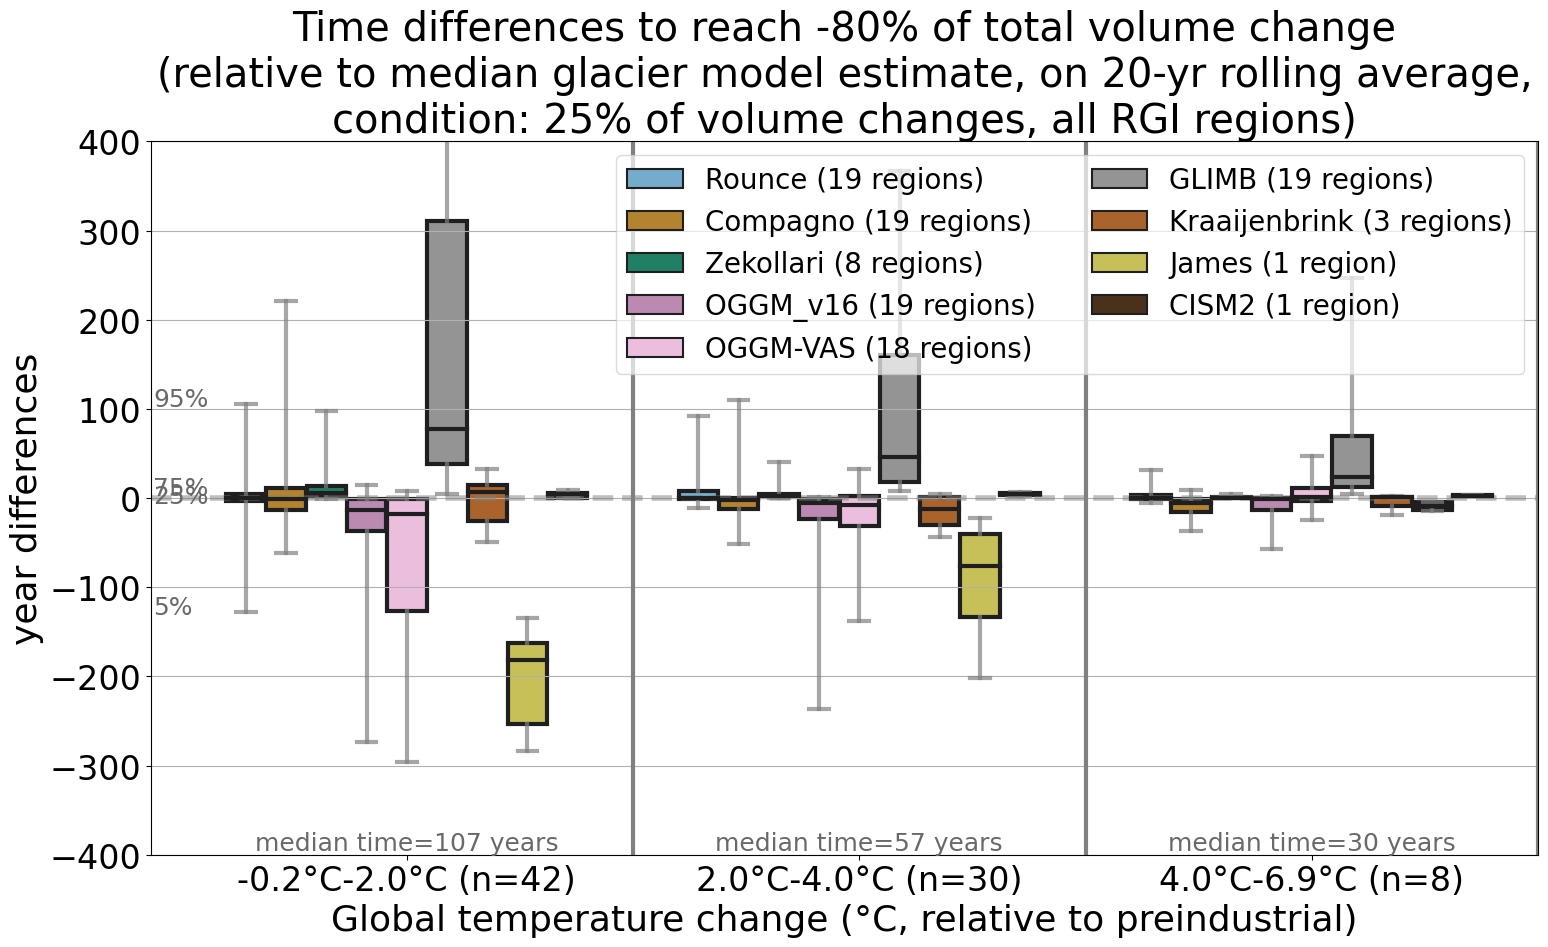

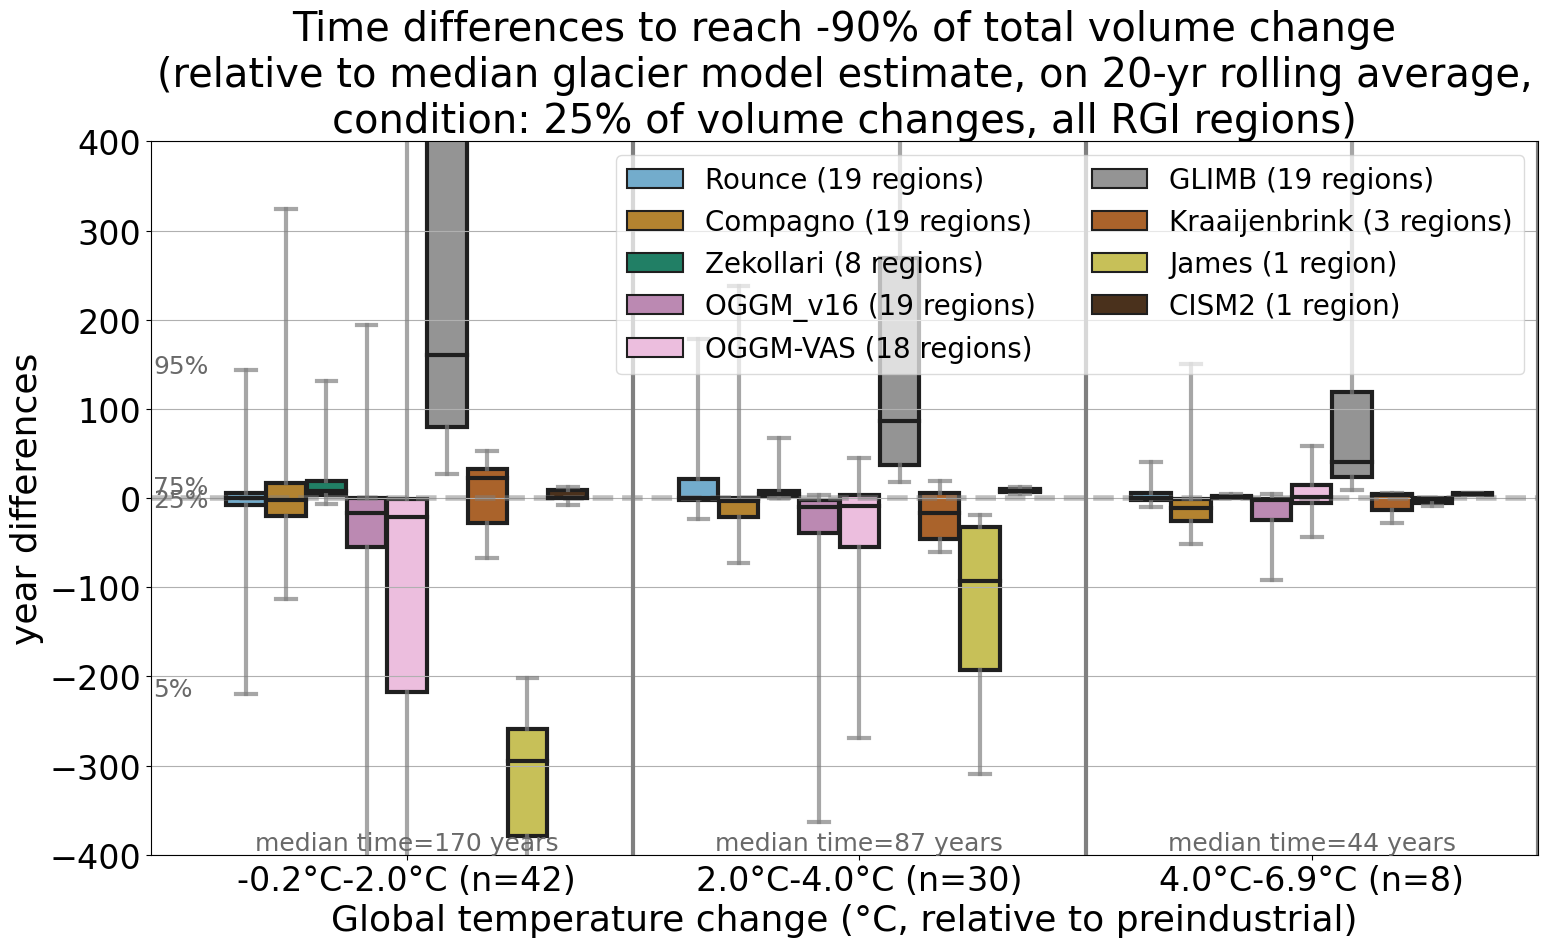

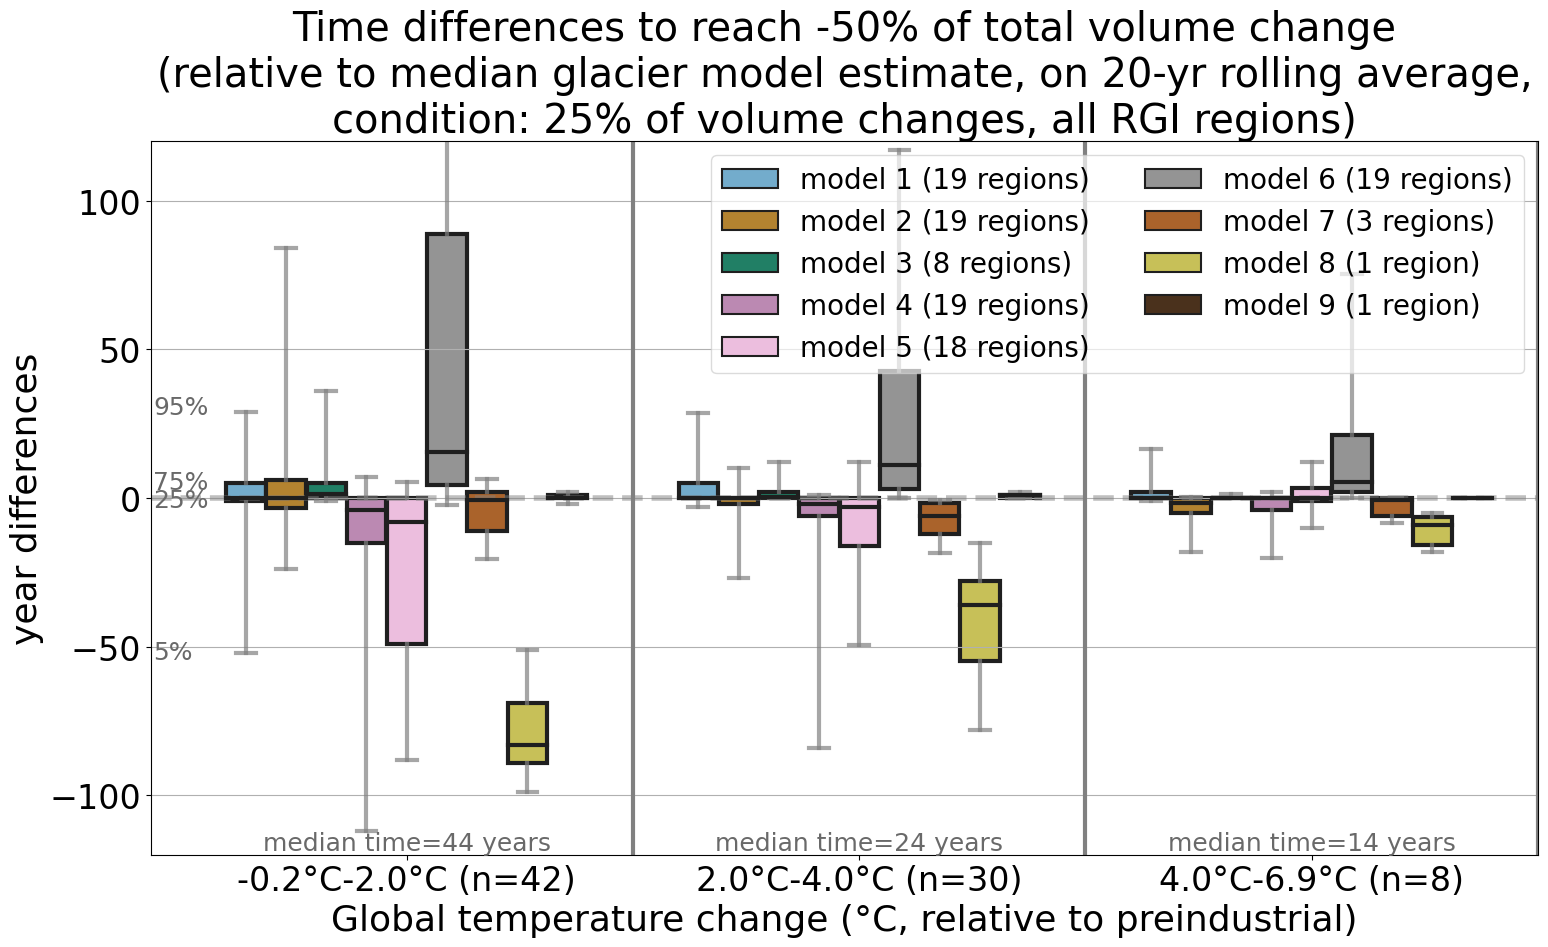

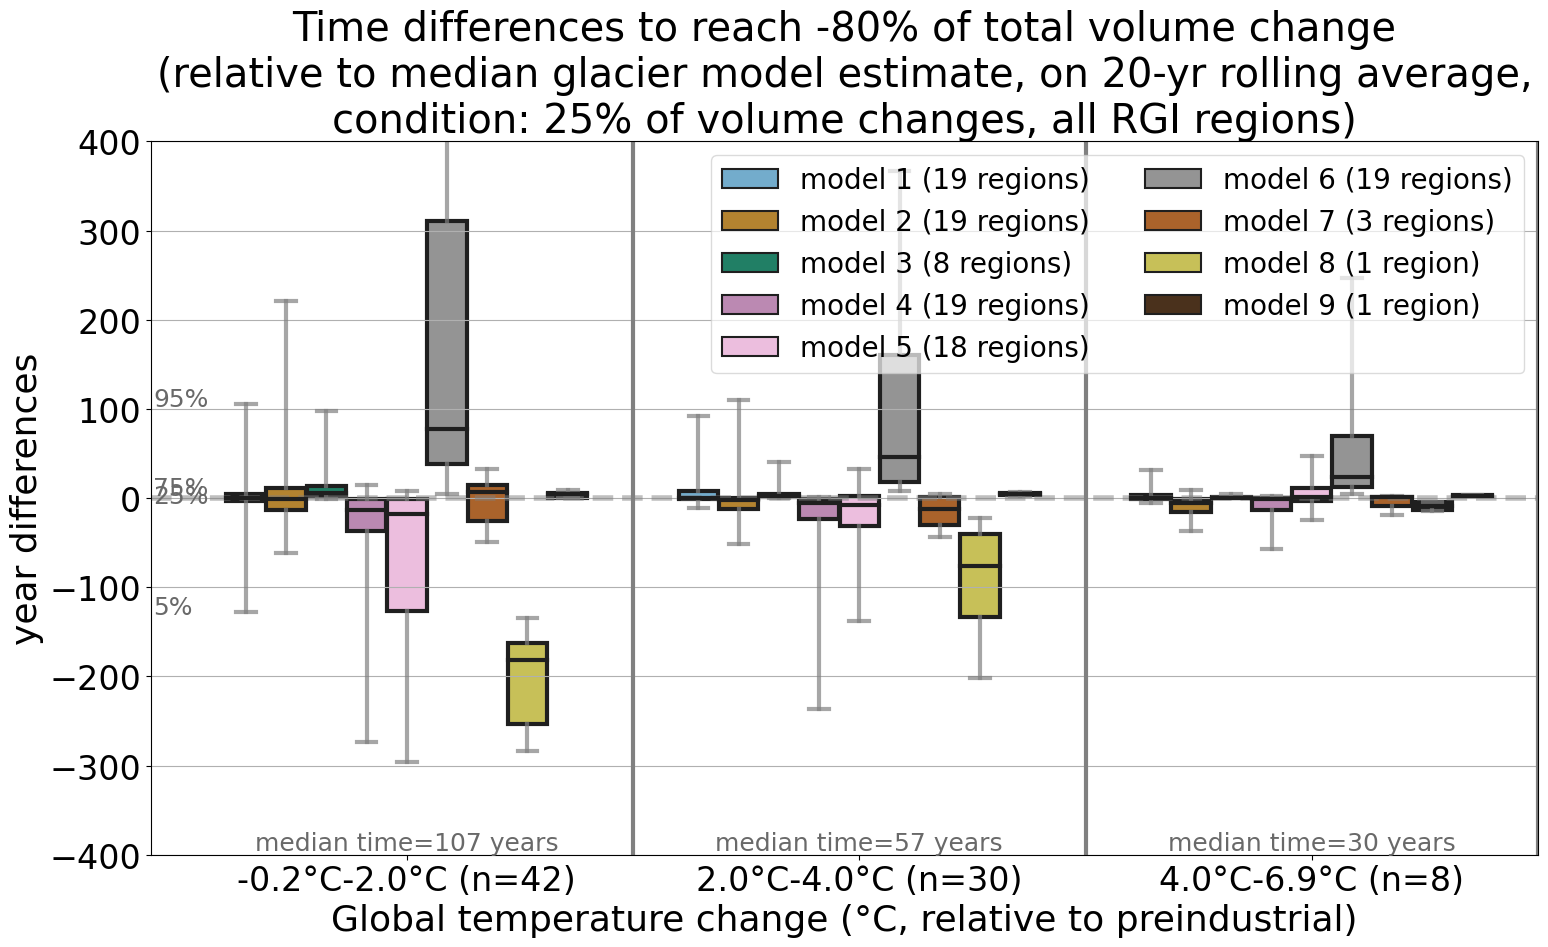

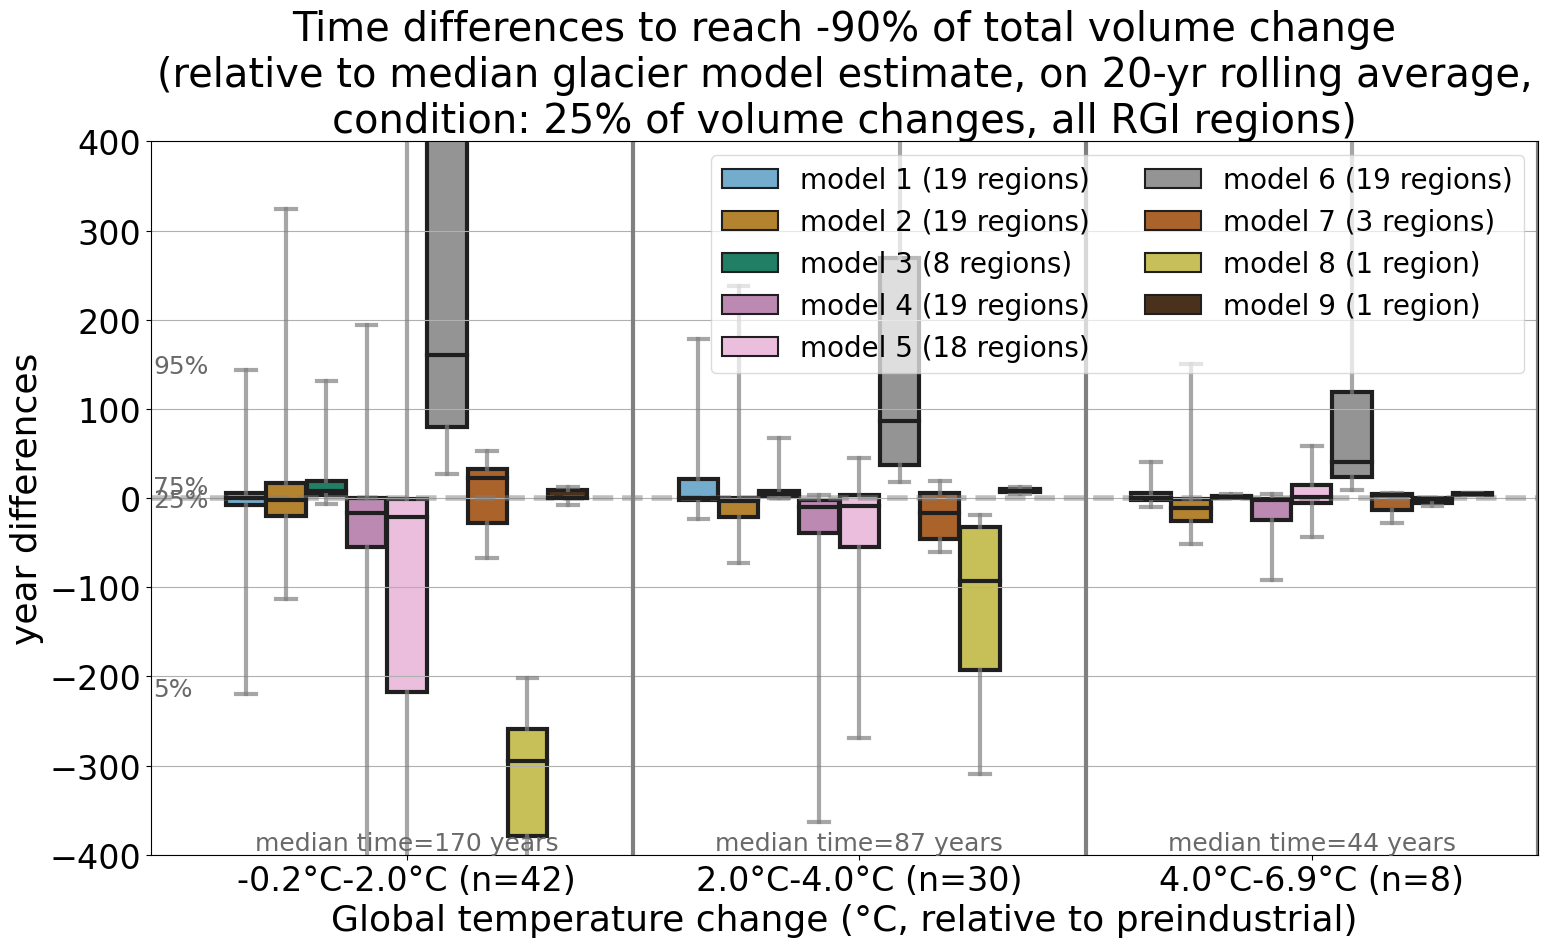

In [121]:

for anonym in ['', '_anonym']:
    for p in [-50,-80,-90]:
        plt.figure(figsize=(16,10))
        plt.rc('font', size=24)  
        sns.boxplot(data=pd_response_time_x_perc_loss_comp, hue='model_author', y=f'diff_resp_time_{p}%',
                    x='temp_ch_classes', palette=pal_models, saturation=0.6,
                       hue_order=hue_order, dodge = True, #hue='ssp',
                                        fliersize=0, whis = [5,95], 
                                        #y = 'time', #hue_order = ['2040', '2100'],
                                        linewidth=3,
                                        capprops={'color':'grey', 'alpha':0.7},
                                        whiskerprops={'color':'grey', 'alpha':0.7},)
        plt.grid(axis='y')
        plt.title(f'Time differences to reach {p}% of total volume change\n(relative to median glacier model estimate, on 20-yr rolling average,\ncondition: 25% of volume changes, all RGI regions)')
        plt.ylabel(r'year differences', fontsize=26)
        plt.xlabel('Global temperature change (°C, relative to preindustrial)', fontsize=26)
        for f in np.arange(0.5,3,1):
            plt.axvline(f, color= 'grey', ls='-', lw=3)

        ax = plt.gca()
        _leg = ax.get_legend()
        handles, labels = ax.get_legend_handles_labels()
        _leg.remove()
        #n = len(hue_order)
        if anonym=='_anonym':
            leg = ax.legend(handles, labels_l_anonym, #title=f'{n} models',
                            loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
        else:
            leg = ax.legend(handles, labels_l, #title=f'{n} models',
                            loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
        if p==-50:
            plt.ylim([-120, 120])
        else:
            plt.ylim([-400, 400])

        qs = pd_response_time_x_perc_loss_comp.groupby(['model_author',
                                                        'temp_ch_classes'])[f'diff_resp_time_{p}%'].quantile([0.05,0.25,
                                                                                                              0.75,0.95]).loc[('Rounce', '-0.2°C-2.0°C (n=42)')].values
        for pp,q in enumerate(qs):
            perci = [5,25,75,95][pp]
            if perci <=75:
                ax.text(-0.56,q-2,f'{perci}%', color = 'dimgrey', fontsize=18)
            else:
                ax.text(-0.56,q*0.98,f'{perci}%', color = 'dimgrey', fontsize=18)
        med_resp_time_temp_ch_classes = pd_response_time_x_perc_loss_comp.groupby('temp_ch_classes').median()[f'resp_time_{p}%']
        plt.axhline(0, ls='--', color='grey', lw=4, alpha = 0.5)

        for e,r in enumerate(med_resp_time_temp_ch_classes.values):
            text = f'median time={int(r)} years'
            if p==-50:
                ax.text(e,0.-120,f'{text}', color = 'dimgrey', fontsize=18, ha='center', va='bottom', zorder=6)
            else:
                ax.text(e,-400,f'{text}', color = 'dimgrey', fontsize=18, ha='center', va='bottom', zorder=6)


        xlim0,xlim1 = ax.get_xlim()
        plt.xlim([-0.565,xlim1])
        plt.tight_layout()
        plt.savefig(f'figures/3_response_time/3_response_time_glacier_model_diff_boxplot_5000yrs{anonym}_{p}%change.png')

### regional 

In [122]:
for r in rgi_regs:
    pd_response_time_x_perc_loss_comp_rgi_reg = pd_response_time_x_perc_loss_comp.loc[pd_response_time_x_perc_loss_comp.rgi_reg=='RGI'+r].dropna()
    rgi_reg = f'RGI{r}'
    rgi_reg_long = f'{d_reg_num_name[r]} ({rgi_reg})'

    for anonym in ['','_anonym']: # --> would need to update the code to have the right legend!!!
        for p in [-50,-80,-90]:
            plt.figure(figsize=(16,10))
            plt.rc('font', size=24)  
            sns.boxplot(data=pd_response_time_x_perc_loss_comp_rgi_reg, hue='model_author', y=f'diff_resp_time_{p}%',
                        x='temp_ch_classes', palette=pal_models, saturation=0.6,
                       hue_order=hue_order, dodge = True, #hue='ssp',
                                            fliersize=0, whis = [5,95], 
                                            #y = 'time', #hue_order = ['2040', '2100'],
                                            linewidth=3,
                                            capprops={'color':'grey', 'alpha':0.7},
                                            whiskerprops={'color':'grey', 'alpha':0.7},)
            plt.grid(axis='y')
            plt.title(f'Time differences to reach {p}% of total volume change\n(relative to median glacier model estimate, on 20-yr rolling average,\ncondition: 25% of volume changes)')
            plt.ylabel(r'year differences', fontsize=26)
            plt.xlabel('Global temperature change (°C, relative to preindustrial)', fontsize=26)
            for f in np.arange(0.5,3,1):
                plt.axvline(f, color= 'grey', ls='-', lw=3)

            ax = plt.gca()



            _leg = ax.get_legend()
            handles, labels = ax.get_legend_handles_labels()
            _leg.remove()
            n = len(hue_order)
            if anonym=='_anonym':
                leg = ax.legend(handles, hue_order_anonymous, #title=f'{n} models',
                                loc='upper right', framealpha = 0.7, ncol=3, fontsize=20)
            else:
                leg = ax.legend(handles, hue_order, #title=f'{n} models',
                                loc='upper right', framealpha = 0.7, ncol=3, fontsize=20)
            ylim0,ylim1 = ax.get_ylim()

            plt.ylim([ylim0*0.8, ylim1*0.8])

            qs = pd_response_time_x_perc_loss_comp_rgi_reg.groupby(['model_author', 'temp_ch_classes'])[f'diff_resp_time_{p}%'].quantile([0.05,0.25,0.75,0.95]).loc[('Rounce', '-0.2°C-2.0°C (n=42)')].values
            for pp,q in enumerate(qs):
                perci = [5,25,75,95][pp]
                if perci <=75:
                    ax.text(-0.56,q,f'{perci}%', color = 'dimgrey', fontsize=18)
                else:
                    ax.text(-0.56,q,f'{perci}%', color = 'dimgrey', fontsize=18)
            med_resp_time_temp_ch_classesreg = pd_response_time_x_perc_loss_comp_rgi_reg.groupby('temp_ch_classes').median()[f'resp_time_{p}%']

            for e,r in enumerate(med_resp_time_temp_ch_classesreg.values):
                text = f'median time={int(r)} years'
                ax.text(e,ylim0*0.8,f'{text}', color = 'dimgrey', fontsize=18, ha='center', va='bottom')

            plt.axhline(0, ls='--', color='grey', lw=4, alpha = 0.5)

            xlim0,xlim1 = ax.get_xlim()
            plt.xlim([-0.565,xlim1])
            plt.tight_layout()
            plt.savefig(f'figures/3_response_time/3_response_time_glacier_model_diff_boxplot_5000yrs{anonym}_{rgi_reg}_{p}%change.png')
            plt.close()

### Old

AttributeError: 'NoneType' object has no attribute 'remove'

<Figure size 3000x4000 with 0 Axes>

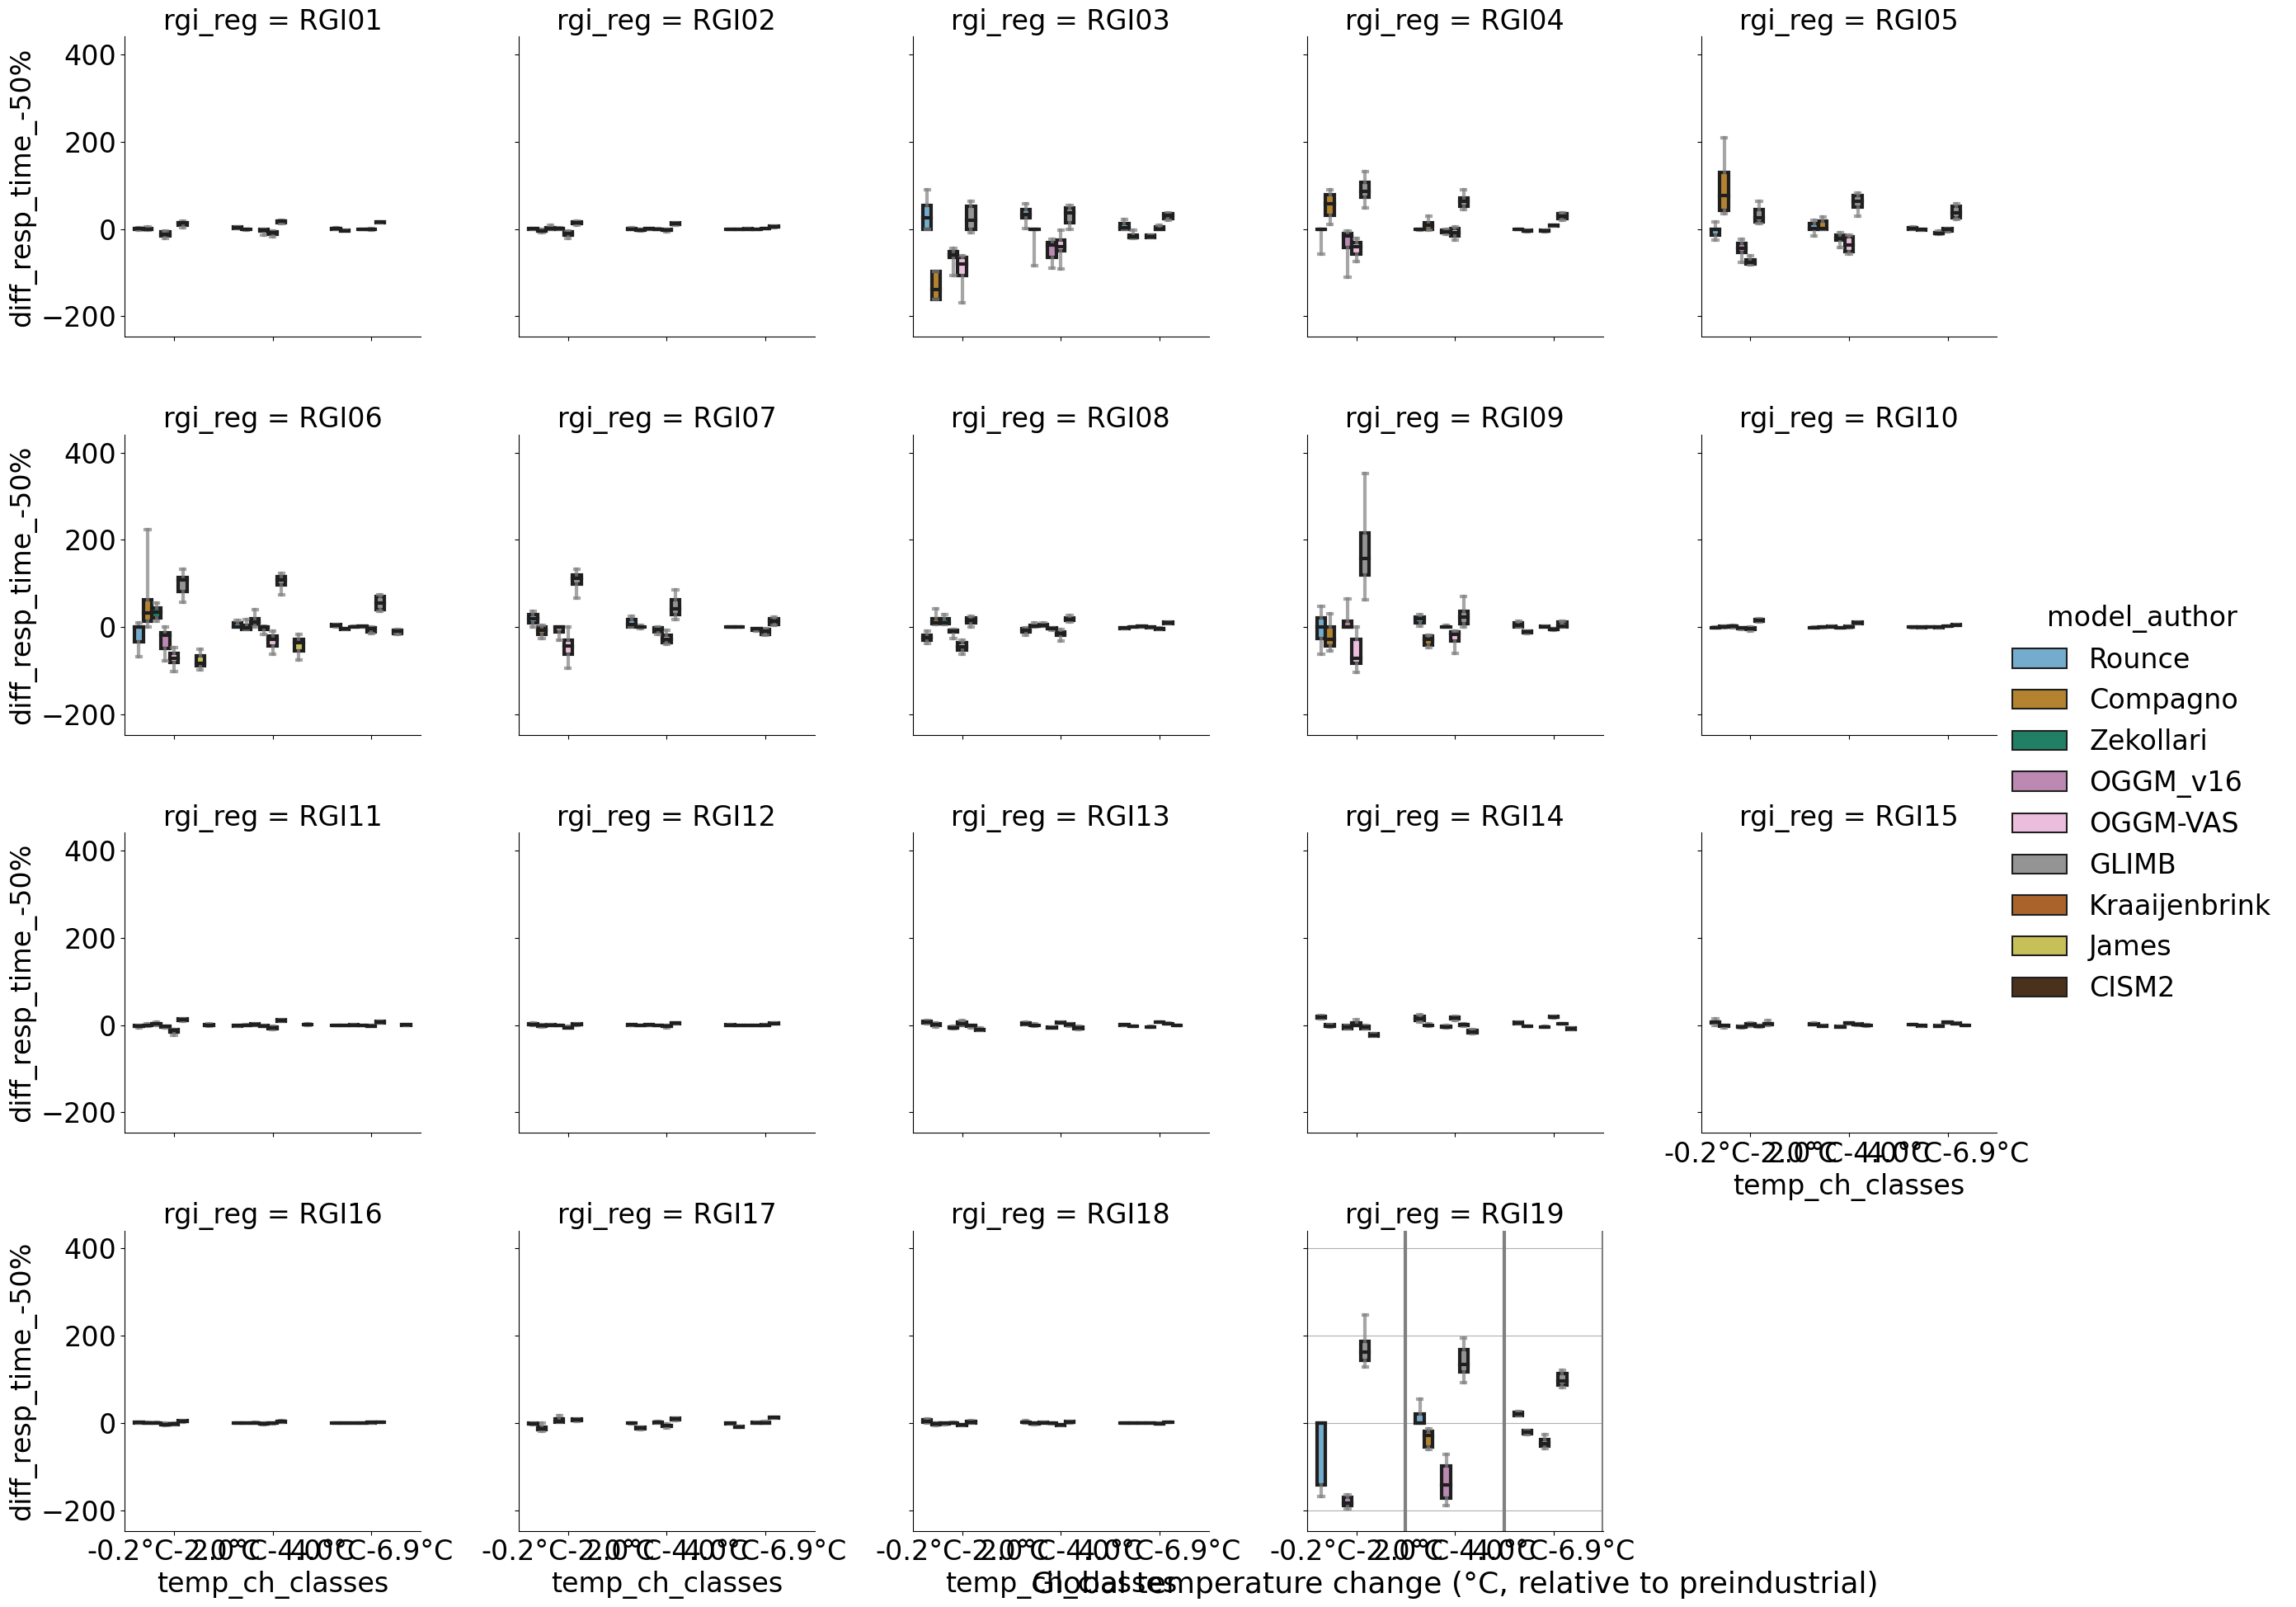

In [88]:

for anonym in ['']: #, '_anonym']:
    plt.figure(figsize=(30,40))
    plt.rc('font', size=24)  
    sns.catplot(data=pd_response_time_50_perc_loss_comp, hue='model_author', y='diff_resp_time_-50%',
                kind='box', col='rgi_reg',col_wrap=5,
                x='temp_ch_classes', palette=pal_models, saturation=0.6,
               hue_order=hue_order, dodge = True, #hue='ssp',
                                    fliersize=0, whis = [5,95], 
                                    #y = 'time', #hue_order = ['2040', '2100'],
                                    linewidth=3,
                                    capprops={'color':'grey', 'alpha':0.7},
                                    whiskerprops={'color':'grey', 'alpha':0.7},)
    plt.grid(axis='y')
    #plt.title('"Response" time differences (relative to median glacier model estimate)\n(condition: 25% of volume changes, def: year where 50% of change occurs, all RGI regions)')
    plt.ylabel(r'"Response" time differences (years)', fontsize=26)
    plt.xlabel('Global temperature change (°C, relative to preindustrial)', fontsize=26)
    for f in np.arange(0.5,3,1):
        plt.axvline(f, color= 'grey', ls='-', lw=3)

    ax = plt.gca()
    _leg = ax.get_legend()
    handles, labels = ax.get_legend_handles_labels()
   # _leg.remove()
    #n = len(hue_order)
    if anonym=='_anonym':
        leg = ax.legend(handles, labels_l_anonym, #title=f'{n} models',
                        loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
    else:
        leg = ax.legend(handles, labels_l, #title=f'{n} models',
                        loc='upper right', framealpha = 0.7, ncol=2, fontsize=20)
    plt.ylim([-120, 120])
    
    qs = pd_response_time_50_perc_loss_comp.groupby(['model_author', 'temp_ch_classes'])['diff_resp_time_-50%'].quantile([0.05,0.25,0.75,0.95]).loc[('Rounce', '-0.2°C-2.0°C')].values
    for p,q in enumerate(qs):
        perci = [5,25,75,95][p]
        if perci <=75:
            ax.text(-0.56,q-2,f'{perci}%', color = 'dimgrey', fontsize=18)
        else:
            ax.text(-0.56,q*0.98,f'{perci}%', color = 'dimgrey', fontsize=18)
    med_resp_time_temp_ch_classes.values
    for e,r in enumerate(med_resp_time_temp_ch_classes.values):
        text = f'median response time={int(r)} years'
        ax.text(e,0.-120,f'{text}', color = 'dimgrey', fontsize=18, ha='center', va='bottom')

    
    xlim0,xlim1 = ax.get_xlim()
    plt.xlim([-0.565,xlim1])
    plt.tight_layout()
    #plt.savefig(f'figures/3_response_time_glacier_model_diff_boxplot_5000yrs{anonym}.png')